In [1]:
import os

import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import scipy

import matplotlib.pyplot as plt

import json
import powerlaw
import imageio
import warnings
import pickle

from fa2 import ForceAtlas2

# create number for each group to allow use of colormap
from itertools import count

In [2]:
%run Utilyties.ipynb

In [3]:
def percentage(part, whole):
  percentage = 100 * float(part)/float(whole)
  return str(round(percentage, 2)) + "%"

In [4]:
def Average(lst):
    return sum(lst) / len(lst)

In [5]:
path = ".."
data = read_data(path+'/data/data_complete.json')

G = init_network(data, True)

In [6]:
G0 = giant_component(G)

# Macro scale

## ForceAtlas2 

In [7]:
forceatlas2 = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                linLogMode=False,  # NOT IMPLEMENTED
                adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,
                multiThreaded=False,  # NOT IMPLEMENTED

                # Tuning
                scalingRatio=2.0,
                strongGravityMode=False,
                gravity=1.0,

                # Log
                verbose=True)

In [37]:
### to get the positions use the file pos.pkl ###

# Attention! This process takes a lot of time. 
# Every time the positions are recalculated, it is necessary to reposition the line
positions = forceatlas2.forceatlas2_networkx_layout(G0, pos=None, iterations=1000)

# saving the positions in a file
a_file = open("pos-1.pkl", "wb") 
pickle.dump(positions, a_file) 
a_file.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:47<00:00,  1.19s/it]

BarnesHut Approximation  took  117.87  seconds
Repulsion forces  took  1052.99  seconds
Gravitational forces  took  1.77  seconds
Attraction forces  took  1.26  seconds
AdjustSpeedAndApplyForces step  took  7.14  seconds


In [8]:
# loading positions from pos.pkl
a_file = open(path+"/pos-1.pkl", "rb")
positions = pickle.load(a_file)

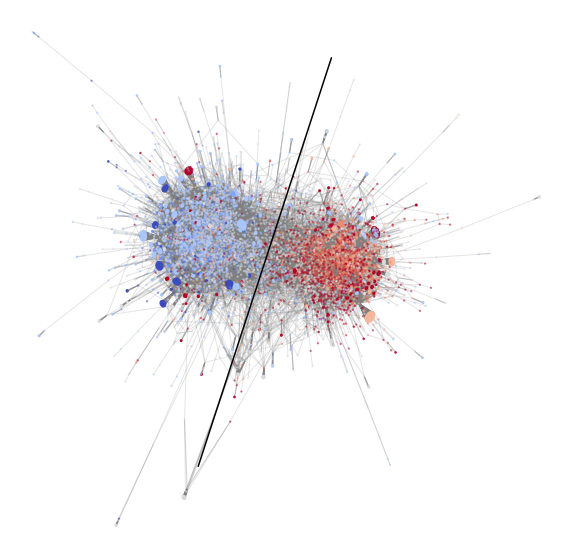

In [9]:
from matplotlib.pyplot import figure
sns.set_style(style='white')
figure(figsize=(10, 10))

nx.draw_networkx_nodes(G0, positions, node_size=2, with_labels=False, 
                       node_color=[G0.nodes[node]['classification'] for node in G0.nodes()], 
                       cmap = 'coolwarm', alpha=0.4)
nx.draw_networkx_edges(G0, positions, edge_color="grey", alpha=0.2)

x = np.linspace(-1000, 1000, 5)
plt.plot(x, 2.5*x-80, linestyle='-', color='black')
plt.axis('off')
plt.show()


In [10]:
# Assigning 'red' or 'blue' value to the "echo_chaber" attribute to network nodes based

for p in positions:
    if (positions[p][1] + -2.6*positions[p][0] - 80 > 0):
        G0.nodes[p]['echo_chamber'] = 'blue'
    else:
        G0.nodes[p]['echo_chamber'] = 'red'

In [11]:
n_red = len([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='red'])
n_blue = len([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='blue'])

print(f"Echo chambers dimensions:\n\nRed\t{n_red}\nBlue\t{n_blue}")

Echo chambers dimensions:

Red	6558
Blue	8325


In [12]:
# creation of two subgraphs, one with the nodes and links of the section below the line (subgraph R), and one with those above it (subgraph B).
H_red = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='red'])
H_blue = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='blue'])

In [13]:
H0_red = giant_component(H_red) #Sottografo R
H0_blue = giant_component(H_blue) #Sottografo B

## Analysis of Red and Blue subgraphs

In [14]:
# percentage of users in favor, against and neutral
def partitions_profiling(g):
    pros = len([x for x,y in g.nodes(data=True) if y['classification']<= -0.5])
    cons = len([x for x,y in g.nodes(data=True) if y['classification']>= 0.5])
    neutrals = (g.number_of_nodes() - pros - cons)
    average = Average([y['classification'] for x,y in g.nodes(data=True)])
    
    print(f"N. supporters: {percentage(pros, g.number_of_nodes())}\n"+
          f"N. opponents: {percentage(cons, g.number_of_nodes())}\n"+
          f"N. neutrals or unclassifiable: {percentage(neutrals, g.number_of_nodes())}\n"+
          f"Average opinion: {round(average,2)}")
    #return pros, cons, neutrals

In [86]:
network_info(H0_red, 'Echo chamber - Red') #Sottografo R

Network information of Echo chamber - Red:
 Nodes: 	6538
 Edges: 	17158

 Average degree: 		5.248699908228816
 Transitivity: 		0.012384476030329725
 Average clustering: 	0.18388801608568714

 Connected components: 	1
 Diameter: 	12

 Density: 	0.0008029218155467059

Average length of shortest paths: 3.742925286856898


In [84]:
partitions_profiling(H0_red) 

N. supporters: 12.01%
N. opponents: 68.29%
N. neutrals or unclassifiable: 19.7%
Average opinion: 1.28


In [32]:
network_info(H0_blue, 'Echo chamber - Blue') #Sottografo B

Network information of Echo chamber - Blue:
 Nodes: 	8324
 Edges: 	17066

 Average degree: 		4.100432484382509
 Transitivity: 		0.00710341352940883
 Average clustering: 	0.11722584267685911

 Connected components: 	1
 Diameter: 	12

 Density: 	0.0004926627999978984

Average length of shortest paths: 3.911933594389383


In [85]:
partitions_profiling(H0_blue)

N. supporters: 75.6%
N. opponents: 9.5%
N. neutrals or unclassifiable: 14.9%
Average opinion: -0.9


In [88]:
print(f"Number of edges between the two echo chambers: {G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges())} ({round((((G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges()))/G0.number_of_edges())*100), 2)}%)")

Number of edges between the two echo chambers: 1958 (5.41%)


### Hubs analysis 

In [15]:
from operator import itemgetter, attrgetter

node_degree = G.degree()
node_degree_r = H0_red.degree()
node_degree_b = H0_blue.degree()

hubs = sorted(node_degree, key=itemgetter(1), reverse=True)
hubs_r = sorted(node_degree_r, key=itemgetter(1), reverse=True)
hubs_b = sorted(node_degree_b, key=itemgetter(1), reverse=True)

C = nx.get_node_attributes(G, 'classification')
C_r = nx.get_node_attributes(H0_red, 'classification')
C_b = nx.get_node_attributes(H0_blue, 'classification')

In [16]:
n = 2 #percentage per thousand of hub nodes on all nodes

npm = int(round(G.number_of_nodes()*n/1000,0)) #percentace of nodes

In [18]:
average_degree_red = 0
average_degree_blue = 0

l_hubs_red = []
l_hubs_blue = []

n_red = 0
n_blue = 0

print(f"\nList of {int(npm)} hubs ({n}%° of nodes of the entire network sorted by degree) \n")
print("Rank\tEC\tUsername\tC\u1D64\tDegree")

i=1
for h in hubs[:npm]: #2%° dei nodi in base al grado
    if H0_red.has_node(h[0]):
        print(f"{i}.\tR\t{h[0][:6]}... \t{round(C[h[0]],1)} \t{h[1]}")
        l_hubs_red.append(h[0])
        average_degree_red += h[1]
        n_red += 1
    else:    
        print(f"{i}.\tB\t{h[0][:6]}... \t{round(C[h[0]],1)} \t{h[1]}")
        l_hubs_blue.append(h[0])
        average_degree_blue += h[1]
        n_blue += 1
    i+=1   
    
print(f"\nAverage hubs degree in the EC Red\t{round(average_degree_red/n_red,1)}")
print(f"Average hubs degree in the EC Blue\t{round(average_degree_blue/n_blue,1)}")


List of 31 hubs (2%° of nodes of the entire network sorted by degree) 

Rank	EC	Username	Cᵤ	Degree
1.	B	6b795e... 	-1 	1179
2.	R	7c5254... 	1.7 	1074
3.	R	5d495a... 	2.2 	855
4.	R	575e5d... 	1 	793
5.	R	7d5e5f... 	0 	788
6.	R	7c525a... 	2.6 	756
7.	B	765a49... 	-1 	702
8.	R	6d524d... 	0 	675
9.	B	495459... 	-3 	608
10.	B	6b4954... 	-3 	545
11.	B	565a55... 	-3 	523
12.	R	775e54... 	1 	517
13.	B	6f5e55... 	0.8 	504
14.	B	495e4b... 	0 	477
15.	B	7d727c... 	0 	445
16.	B	565a4e... 	-1 	402
17.	B	6d5a57... 	-1 	398
18.	B	717d68... 	-0.8 	371
19.	R	484f49... 	0.8 	359
20.	B	7a5759... 	-1 	348
21.	B	585352... 	0 	346
22.	R	7c524e... 	1.5 	332
23.	B	4b525e... 	-3 	323
24.	R	7e485e... 	-0.9 	315
25.	B	4b5e49... 	-1 	309
26.	B	565a49... 	-3 	307
27.	B	774e58... 	-3 	286
28.	B	7a6e55... 	-0.4 	279
29.	B	6f5241... 	2 	268
30.	B	565c5a... 	-0.8 	261
31.	B	6d524d... 	-0.9 	237

Average hubs degree in the EC Red	646.4
Average hubs degree in the EC Blue	434.2


In [19]:
hubs = set.union(set(l_hubs_blue), set(l_hubs_red))

In [20]:
snapshots = get_snapshot(path+"/data/data_complete.json", ranges)

In [21]:
G = nx.Graph()
c = nx.Graph()

c_red = nx.Graph()
c_blue = nx.Graph()

n_nodes = []
n_nodes_favore = []
n_nodes_contro = []
n_nodes_neutri = []

r_hubs = 0
b_hubs = 0
n_hubs = 0

l_r_hubs = []
l_b_hubs = []
l_n_hubs = []

perc_net = []
r_perc_ego = []
b_perc_ego = []

time = 1

for snap, dates in zip(snapshots, ranges):
    
    print(f"--- Network dal: {dates[0]} al {dates[-1]} (Tempo {time})--- \n")
    build_network(snap, G, True)
    
    n_nodes.append(G.number_of_nodes())
    n_nodes_contro.append(G.subgraph([x for x,y in G0.nodes(data=True) if y['classification']>=0.5]).number_of_nodes())
    n_nodes_favore.append(G.subgraph([x for x,y in G0.nodes(data=True) if y['classification']<=-0.5]).number_of_nodes())
    n_nodes_neutri.append(G.subgraph([x for x,y in G0.nodes(data=True) if (y['classification']>-0.5) & (y['classification']<0.5)]).number_of_nodes())
    
    for node in hubs:
        if G.has_node(node):
            n_hubs += 1
            node_ego = nx.ego_graph(G, node)
            c = nx.compose(c, node_ego)
            if node in l_hubs_red:
                c_red = nx.compose(c_red, node_ego)
                r_hubs += 1
            elif node in l_hubs_blue:
                c_blue = nx.compose(c_blue, node_ego)
                b_hubs += 1
                
    l_r_hubs.append(r_hubs)
    l_b_hubs.append(b_hubs)
    l_n_hubs.append(n_hubs)
    
    perc_net.append(round(c.number_of_nodes()/G.number_of_nodes()*100, 2))
    r_perc_ego.append(round(c_red.number_of_nodes()/c.number_of_nodes()*100, 2))
    b_perc_ego.append(round(c_blue.number_of_nodes()/c.number_of_nodes()*100, 2))
    
    print(f"Hubs: {n_hubs}" + 
          f"\nNodes connected to the hubs: {c.number_of_nodes()} ({perc_net[-1]}% of the network)" + #Numero totale di nodi dell'unione delle ego-networks degli hubs
          f"\nHubs in the subgraph R: {r_hubs}" +
          f"\n\tNodes connected to the hubs in the subgraph R: {c_red.number_of_nodes()} ({round(c_red.number_of_nodes()/G.number_of_nodes()*100, 2)}% of the network" +
          f"\nHubs in the subgraph B: {b_hubs}" +
          f"\n\tNodes connected to the hubs in the subgraph B: {c_blue.number_of_nodes()} ({round(c_blue.number_of_nodes()/G.number_of_nodes()*100, 2)}% of the network" + 
          f"\nNodes connected to both hubs in subgraph R and B: {-c.number_of_nodes()+c_red.number_of_nodes()+c_blue.number_of_nodes()} ({round((-c.number_of_nodes()+c_red.number_of_nodes()+c_blue.number_of_nodes())/G.number_of_nodes()*100, 2)}% of the network)\n\n")
    
    r_hubs = 0
    b_hubs = 0
    n_hubs = 0
    time += 1

--- Network dal: 2021-06-10 al 2021-06-14 (Tempo 1)--- 

Hubs: 4
Nodes connected to the hubs: 15 (19.23% of the network)
Hubs in the subgraph R: 3
	Nodes connected to the hubs in the subgraph R: 12 (15.38% of the network
Hubs in the subgraph B: 1
	Nodes connected to the hubs in the subgraph B: 3 (3.85% of the network
Nodes connected to both hubs in subgraph R and B: 0 (0.0% of the network)


--- Network dal: 2021-06-15 al 2021-06-19 (Tempo 2)--- 

Hubs: 6
Nodes connected to the hubs: 19 (18.63% of the network)
Hubs in the subgraph R: 3
	Nodes connected to the hubs in the subgraph R: 12 (11.76% of the network
Hubs in the subgraph B: 3
	Nodes connected to the hubs in the subgraph B: 7 (6.86% of the network
Nodes connected to both hubs in subgraph R and B: 0 (0.0% of the network)


--- Network dal: 2021-06-20 al 2021-06-24 (Tempo 3)--- 

Hubs: 19
Nodes connected to the hubs: 1893 (56.11% of the network)
Hubs in the subgraph R: 8
	Nodes connected to the hubs in the subgraph R: 871 (25.82% 

In [22]:
columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
df_net_growth = pd.DataFrame([n_nodes_favore, n_nodes_contro, n_nodes], 
                                columns = columns, 
                                index = ['pro', 'cons', 'all'])
df_net_growth

,T1,T2,T3,T4,T5,T6,T7
pro,43,56,1593,6738,6976,7005,7093
cons,26,33,1352,4982,5216,5222,5260
all,78,102,3374,14332,15113,15174,15378


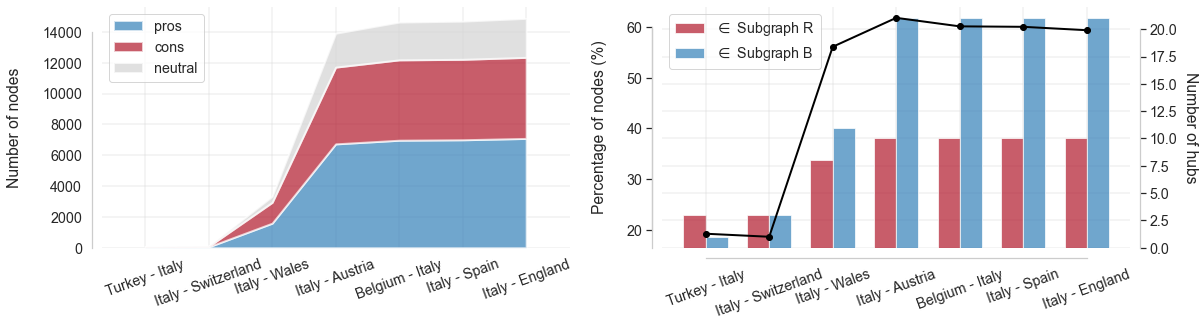

In [23]:
labels = ["Turkey - Italy", 
          "Italy - Switzerland", 
          "Italy - Wales", 
          "Italy - Austria", 
          "Belgium - Italy", 
          "Italy - Spain", 
          "Italy - England"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

sns.set(rc={'figure.figsize':(17,4.8), "lines.linewidth": 0.9, "grid.linewidth": 0.4}, font_scale=1.3)
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, sharex=True)

y=[n_nodes_favore, n_nodes_contro, n_nodes_neutri]
ax[0].stackplot(x,y, 
                colors = ['#3480b9', '#b1182b', '#d4d4d452'],  alpha=.7,  
                labels=['pros','cons', 'neutral'], 
                linewidth=2)
ax[0].set_ylabel('Number of nodes', rotation=90, labelpad=20)
ax[0].set_xticks(x)
ax[0].legend(loc='upper left')
ax[0].set_xticklabels(labels, rotation=20)

ax[1].plot(perc_net,
         linestyle='-',
         marker='o', color='black', linewidth=2.0)


ax2 = ax[1].twinx()
ax2.bar(x - width/2, l_r_hubs, width, color = '#b1182b', alpha=.7, label=r'$\in$ Subgraph R')
ax2.bar(x + width/2, l_b_hubs, width, color = '#3480b9', alpha=.7, label=r'$\in$ Subgraph B')

ax2.set_ylabel('Number of hubs', rotation=-90, labelpad=20)
ax2.legend(loc='upper left')

# move ax in front
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)

ax[1].set_ylabel('Percentage of nodes (%)', labelpad=20)
ax[1].set_xticks(x)
ax[1].yaxis.grid(False)

sns.despine(top=True, right=True, left=False, bottom=True, offset=10, trim=True, ax = ax[0])
sns.despine(top=True, right=False, left=False, bottom=True, offset=10, trim=True, ax = ax2)
sns.despine(top=True, right=False, left=False, bottom=True, offset=10, trim=True, ax = ax[1])
sns.despine(offset=10, trim=True, ax = ax[1])

ax[1].set_xticklabels(labels, rotation=20)

fig.tight_layout()
plt.show()

# Micro scale

In order to make our research more consistent, we choose to carry out this analysis on the users who wrote at least two tweets.

In [25]:
df = pd.DataFrame(data)

n_users = df.user.value_counts()
user_list_occ = df[df.user.isin(n_users.index[n_users.gt(1)])].groupby('user').mean() # lista di utenti autori di almeno 2 tweet

In [26]:
def discretize_opinion(G):
    for node in G.nodes():
        if G.nodes[node]['classification'] < 0.5 and G.nodes[node]['classification'] > -0.5:
            G.nodes[node]['classification'] = 0
        elif G.nodes[node]['classification'] >= 0.5:
            G.nodes[node]['classification'] = 1
        else:
            G.nodes[node]['classification'] = -1

In [27]:
def get_ass_mix(G):
    discretize_opinion(G) # discretizza l'opinione in -1 (a favore), 1 (contrari), 0 (neutri/non classificabili)
    return nx.attribute_assortativity_coefficient(G, "classification") 

In [28]:
# studio sulla  opinione media dei vicini CN(u) rispetto all’opinione media di un utente Cu
def neighbors_av_opinion(G, T, lista_ass_mix): 
    nx.set_node_attributes(G, 0, "neighbours_opinion") # inizializzazione dell'attributo
    
    # calcolo e assegnazione del valore dell'attributo neighbours_opinion ad ogni nodo
    for node in G.nodes():
        if node in user_list_occ.index: 
            for n in(G.neighbors(node)):
                G.nodes[node]['neighbours_opinion'] += G.nodes[n]["classification"]
            if (G.degree[node] != 0): 
                G.nodes[node]['neighbours_opinion'] = G.nodes[node]['neighbours_opinion']/G.degree[node]
            else:
                G.nodes[node]['neighbours_opinion'] = G.nodes[node]['classification']
    
    # creazione del dizionario
    n_class = {}
    for node in G.nodes():
        if node in user_list_occ.index:
            n_class[node] = [G.nodes[node]['classification']]
            n_class[node].append(G.nodes[node]['neighbours_opinion'])
    
    # creazione del dataframe
    df_class = pd.DataFrame.from_dict(n_class, orient='index',
                           columns=['opinion','neighbours_opinion'])
    
    # discretizzazione dell'opinione 
    df_class["class"] = np.where(
        df_class["opinion"] >= 0.5, 'Cons', 
        np.where(df_class["opinion"] <= -0.5, 'Pros', 'Neutral')
    )
    
    ### PLOT ###
    plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_facecolor("black")
    
    ax = sns.kdeplot(data = df_class,  x = "opinion", y = "neighbours_opinion", 
                fill=True, thresh=0, levels=100, cmap="CMRmap") #ax=axes[T]) #o mako
    ax.set(xlim=(-3, 3), ylim=(-3, 3))
    ax.set_xlabel('$C_{u}$', fontsize = 26)
    ax.set_ylabel('$C_{N(u)}$', fontsize = 26)
    
    # calcolo del p-value e del coefficiente di pearson 
    r, p = scipy.stats.pearsonr(df_class['opinion'], df_class['neighbours_opinion'])
    print(f"Pearson coefficient: {round(r,2)}\tp-value: {round(p,4)} \n")
    
    # calcolo dell'assortative mixing 
    G_tmp = G.copy()
    lista_ass_mix.append(get_ass_mix(G_tmp))
    
    ax.tick_params(axis='both', labelsize=16)
    
    tempo = T+1
    ax.text(x=0.04, y=0.96, transform = ax.transAxes, s="$ρ = %.2f$" % r,\
        fontsize=26, verticalalignment='top', horizontalalignment='left', color='white')
    ax.text(x=0.04, y=0.84, transform = ax.transAxes, s="$r = %.2f$" % lista_ass_mix[T],\
        fontsize=26, verticalalignment='top', horizontalalignment='left', color='white')
    ax.text(x=0.80, y=0.13, transform = ax.transAxes, s=r"t = %.0f" % tempo,\
        fontsize=26, verticalalignment='top', horizontalalignment='left', color='white')
    
    # create file name and append it to a list
    #filename = f'Density_2tweets_{T}.png'
    #filenames.append(filename)
    
    # save frame
    #plt.savefig(filename, transparent=True)
    #plt.close()
    
    plt.show()    

Pearson coefficient: 0.49	p-value: 0.0001 



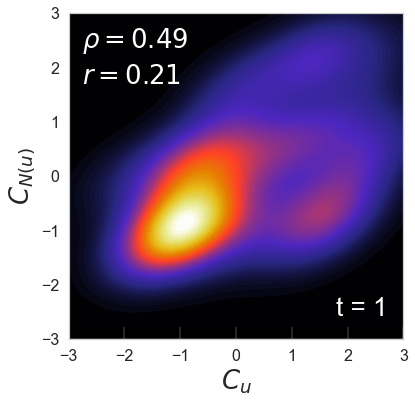

Pearson coefficient: 0.51	p-value: 0.0 



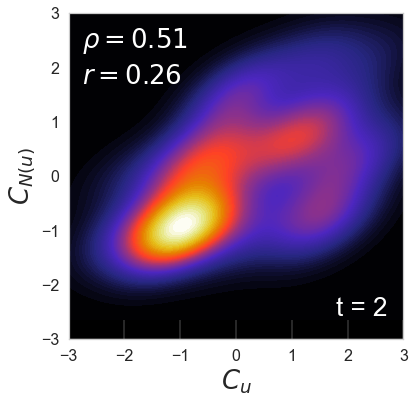

Pearson coefficient: 0.72	p-value: 0.0 



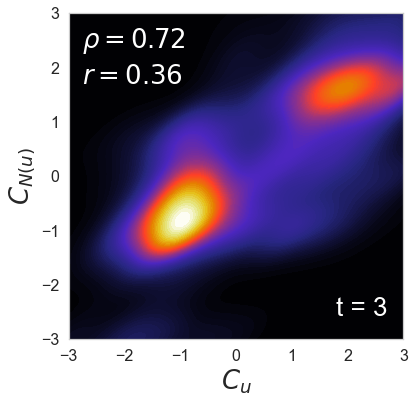

Pearson coefficient: 0.85	p-value: 0.0 



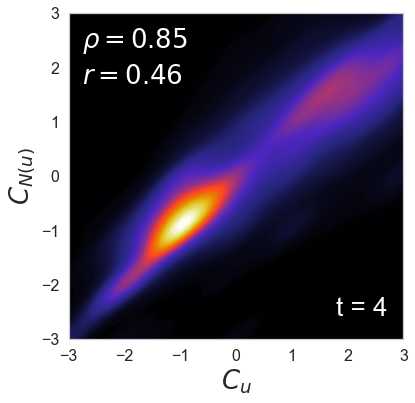

Pearson coefficient: 0.86	p-value: 0.0 



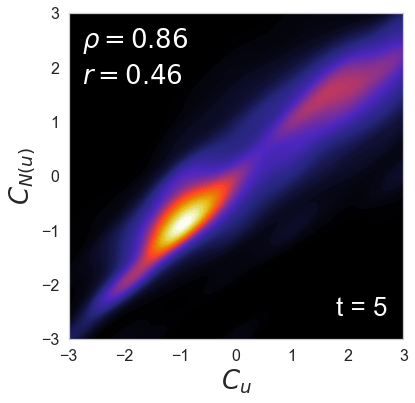

Pearson coefficient: 0.86	p-value: 0.0 



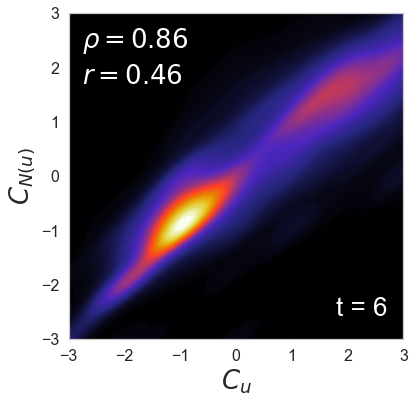

Pearson coefficient: 0.86	p-value: 0.0 



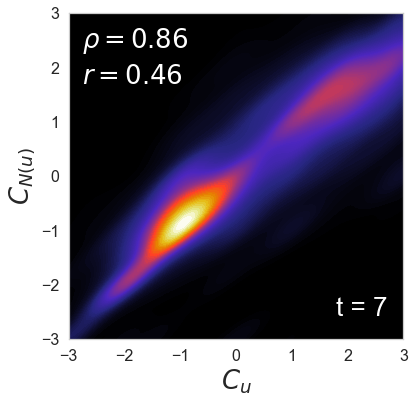

In [31]:
G=nx.Graph()
T = 0
lista_ass_mix = []
filenames = []   

for snap in snapshots:
    build_network(snap, G, True)
    neighbors_av_opinion(G, T, lista_ass_mix)
    T += 1  